<a href="https://colab.research.google.com/github/Daniel-Wait/SKRIPSIE_workbooks/blob/master/SKRIPSIE_codes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
DB WAIT
20887507

"""
%matplotlib inline
%load_ext autoreload
%autoreload 2
import math
import numpy as np
from matplotlib import pylab as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Import different modules for using with the notebook
from IPython.display import display
from IPython.display import Image
from IPython.display import HTML

#A helper-function to setup a proper plot
def setup_plot(title, y_label='', x_label='', newfig=True):
  if newfig:
    plt.figure()
  plt.margins(*(plt.array(plt.margins())+0.05))
  plt.title(title)
  plt.ylabel(y_label)
  plt.xlabel(x_label)


def fsk(bitseq, spb, f_0, f_1, F):
  T = 1/F  
  nb = bitseq.shape[0]
  num = np.array(range(0, spb))
  mn = np.zeros(shape = (spb*nb,))
  mn_len = np.array(range(0, mn.shape[0]))
  
  for i in range(0, nb):
    if (bitseq[i] == 1): 
      bit = np.sin(2*f_1*np.pi*num*T)
    if (bitseq[i] == 0):
      bit = np.sin(2*f_0*np.pi*num*T)
    mn[i*spb:(i+1)*spb] = bit

  #setup_plot("Modulated Signal")
  #plt.plot(mn, 'c')
  #plt.show()
  
  return mn

def pollute(bitseq, len_f, len_b, spb, f_0, f_1, F, gain, timeshift, noise_stddev):
  T = 1/F  
  nb = bitseq.shape[0]
  num = np.array(range(0, spb)) 
  rn = np.zeros(shape = (spb*nb,))
  phase1 = 2*np.pi*f_1*timeshift
  phase0 = 2*np.pi*f_0*timeshift

  for i in range(0, nb):
    if (bitseq[i] == 1): 
      bit = np.sin(2*f_1*np.pi*num*T + phase1)
    if (bitseq[i] == 0):
      bit = np.sin(2*f_0*np.pi*num*T + phase0)
    rn[i*spb:(i+1)*spb] = bit
  
  rn = np.insert(rn, 0, np.zeros(shape = (len_f,)) )
  rn = np.append(rn, np.zeros(shape = (len_b,)) )
  wn = np.random.normal(loc=0.0, scale=noise_stddev, size=(nb*spb + len_f + len_b,))
  rn = gain*rn + wn
  
  #setup_plot("Received Signal")
  #plt.plot(rn, 'm')
  #plt.show()
  
  return rn

def chirp_fsk(bitseq, spb, f_0, f_1, F, df):
  T = 1/F  
  nb = bitseq.shape[0]
  num = np.array(range(0, spb))
  mn = np.zeros(shape = (spb*nb,))
  mn_len = np.array(range(0, mn.shape[0]))
  chirp = np.array(range(0,spb))*(df/spb)

  #print(chirp+f_1)

  for i in range(0, nb):
    if (bitseq[i] == 1): 
      bit = np.sin(2*(f_1+chirp)*np.pi*num*T)
    if (bitseq[i] == 0):
      bit = np.sin(2*(f_0-chirp)*np.pi*num*T)
    mn[i*spb:(i+1)*spb] = bit
  
  #setup_plot("Modulated Signal")
  #plt.plot(mn, 'c')
  #plt.show()

  return mn

def chirp_pollute(bitseq, len_f, len_b, spb, f_0, f_1, F, gain, timeshift, noise_stddev, df):
  T = 1/F  
  nb = bitseq.shape[0]
  num = np.array(range(0, spb)) 
  rn = np.zeros(shape = (spb*nb,))
  phase1 = 2*np.pi*f_1*timeshift
  phase0 = 2*np.pi*f_0*timeshift
  chirp = np.array(range(0,spb))*(df/spb)

  for i in range(0, nb):
    if (bitseq[i] == 1): 
      bit = np.sin(2*(f_1+chirp)*np.pi*num*T + phase1)
    if (bitseq[i] == 0):
      bit = np.sin(2*(f_0-chirp)*np.pi*num*T + phase0)
    rn[i*spb:(i+1)*spb] = bit
  
  rn = np.insert(rn, 0, np.zeros(shape = (len_f,)) )
  rn = np.append(rn, np.zeros(shape = (len_b,)) )
  wn = np.random.normal(loc=0.0, scale=noise_stddev, size=(nb*spb + len_f + len_b,))
  rn = gain*rn + wn
  
  return rn


def downsample(input, len, factor):
  output = input[:len:factor]
  return output


def xnor_autocorr(x):
  N = x.shape[0]
  y = x
  rxx = np.zeros(shape = (N,), dtype = np.float32 )

  for i in range(0,N):
    #rxx[i+N-1] = np.sum( x[0:N-i]*y[i:N] )
    for n in range(0, N-i):
      if (x[n] == y[n+i]):
        rxx[i] = rxx[i] + 1

  rxx = np.insert(rxx, 0, np.flip(rxx[1:N]))
  return rxx


def xnor_xcorr(x, y):
  N = x.shape[0]
  rxx = np.zeros(shape = (2*N-1,), dtype = np.float32 )
  r2 = np.zeros(shape = (2*N-1,), dtype = np.float32 )
  
  for i in range(0,N):
    #rxx[i+N-1] = np.sum( y[0:N-i]*x[i:N] )
    for n in range(0, N-i):
      if (y[n] == x[n+i]):
        rxx[i+N-1] = rxx[i+N-1] + 1

  for i in range(0,N):
      #rxx[N-i-1] = np.sum( x[0:N-i]*y[i:N] )
      for n in range(0, N-i):
        if (x[n] == y[n+i]):
          rxx[N-i-1] = rxx[N-i-1] + 1
  rxx[N-1] = rxx[N-1]/2
  """

  for i in range(0,N):
    for n in range(0, N-i):
      if (y[n] == x[n+i]):
        r1[i+N-1] = r1[i+N-1] + 1


  
  for n in range(0,i):
    rxx[i] = rxx[i] + x[n]*y[N-i+n]
    
  """
      

      
  """for i in range(0,N):
      for n in range(0, N-i):
        if (x[n] == y[n+i]):
          rxx[N-1-i] = rxx[i] + 1"""

  """for i in range(0,N):
      #rxx[N-i-1] = np.sum( x[0:N-i]*y[i:N] )
      for n in range(0, N-i):
        if (x[n] == y[n+i]):
          rxx[N-i-1] = rxx[i] + 1"""

  return rxx


def show_corr_outs(bitseq, f0, f1, fs, samps, dsamp, delta_f):
  print(bitseq.shape[0])
  rbb = np.correlate(bitseq, bitseq, mode = "full")
  #print(rbb.shape)
  #print(rbb)
  setup_plot("1/0 Binary xCorr")
  plt.plot(rbb)
  plt.show()

  rrr = xnor_autocorr(bitseq)
  setup_plot("CUSTOM Binary xCorr")
  plt.plot(rrr)
  plt.show()

  #STANDARD FSK
  tx = fsk(bitseq = bitseq, spb = samps, f_0 = f0, f_1 = f1, F = fs)
  tx = downsample(tx, bitseq.shape[0]*samps, dsamp)

  rx = pollute(bitseq=bitseq, len_f = 0, len_b = 0, spb = samps, f_0 = f0, f_1 = f1, F = fs, gain = 1, timeshift = 0, noise_stddev = 0)
  rx = downsample(rx, bitseq.shape[0]*samps, dsamp)

  rtr = np.correlate(rx, tx, mode = "full")
  setup_plot("Standard FSK Modulated xCorr")
  plt.plot(rtr)
  plt.show()

  #CHIRPED FSK
  ctx = chirp_fsk(bitseq = bitseq, spb = samps, f_0 = f0, f_1 = f1, F = fs, df = delta_f*4)
  ctx = downsample(ctx, bitseq.shape[0]*samps, dsamp)

  crx = chirp_pollute(bitseq=bitseq, len_f = 0, len_b = 0, spb = samps, f_0 = f0, f_1 = f1, F = fs, gain = 1, timeshift = 0, noise_stddev = 0, df = delta_f*4)
  crx = downsample(crx, bitseq.shape[0]*samps, dsamp)

  crtr = np.correlate(crx, ctx, mode = "full")
  setup_plot("Chirped FSK ModulatedxCorr")
  plt.plot(crtr)
  plt.show()
  """
  #CONFUSION
  wrtr = np.correlate(rx, ctx, mode = "full")
  setup_plot("xCorr of Chirped and Standard FSK (same message)")
  plt.plot(wrtr)
  plt.show()

  ectx = chirp_fsk(bitseq = bitseq, spb = samps, f_0 = f0, f_1 = f1, F = fs, df = delta_f*4/2)
  ectx = downsample(ectx, bitseq.shape[0]*samps, dsamp)

  ertr = np.correlate(rx, ectx, mode = "full")
  setup_plot("xCorr of Different Sweep widths")
  plt.plot(ertr)
  plt.show()
  """

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#https://stackoverflow.com/questions/22227595/convert-integer-to-binary-array-with-suitable-padding

def vec_bin_array(arr, m):
    """
    Arguments: 
    arr: Numpy array of positive integers
    m: Number of bits of each integer to retain

    Returns a copy of arr with every element replaced with a bit vector.
    Bits encoded as int8's.
    """
    to_str_func = np.vectorize(lambda x: np.binary_repr(x).zfill(m))
    strs = to_str_func(arr)
    ret = np.zeros(list(arr.shape) + [m], dtype=np.int8)
    for bit_ix in range(0, m):
        fetch_bit_func = np.vectorize(lambda x: x[bit_ix] == '1')
        ret[...,bit_ix] = fetch_bit_func(strs).astype("int8")

    return ret 

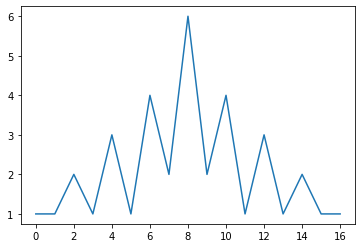

In [ ]:
x = np.array([1,0,1,0,1,0,1,1,1])
y = np.array([1,0,1,0,1,0,1,1,1])

rxy = np.correlate(x, y, mode = "full")
plt.plot(rxy)
plt.show()

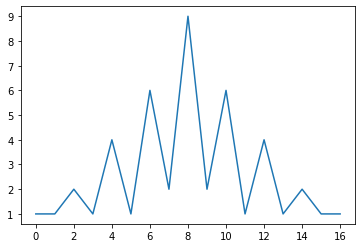

In [ ]:
rxy = xnor_autocorr(x)
plt.plot(rxy)
plt.show()

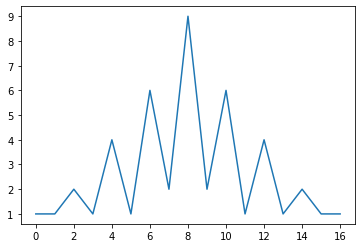

6.0


In [ ]:
rxy = xnor_xcorr(x, y)

plt.plot(rxy)
plt.show()

print(rxy[6])

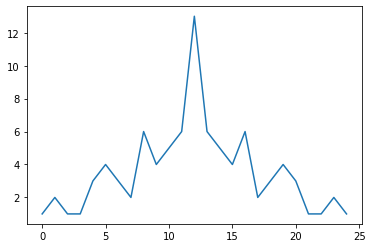

In [168]:
x = np.array([0,0,1,1,1,0,1,0,0,0,1,0,0])
rxx = xnor_xcorr(x, x)

plt.plot(rxx)
plt.show()

In [169]:
print(rxx[12])

13.0


#Initialize Variables

In [ ]:
fs = 44100
Ts = 1/fs

Tb = 20e-3
samps = int(Tb*fs) 
print(samps)

n = 1
delta_f = n/(2*Tb)
print(delta_f)

#f1 = delta_f*10
f1 = delta_f*32
f0 = delta_f*16
print(f0, f1)

dsamp = 2
blocks = 6
L = 1024
N = L*2
print(dsamp, blocks, L, N)

882
25.0
400.0 800.0
2 6 1024 2048


#Maximum of FSK Correlation

*For N-bit message and L samples/bit*

**Result:**

  rxx_max = N*L/2

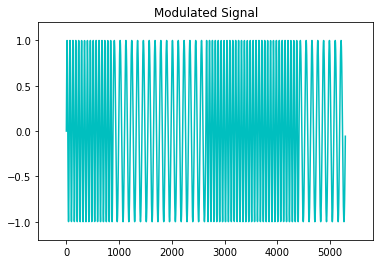

2646.0


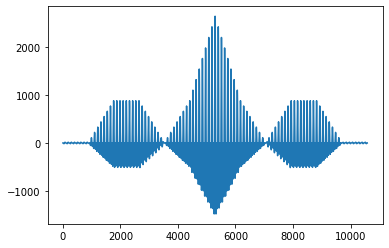

2205.0


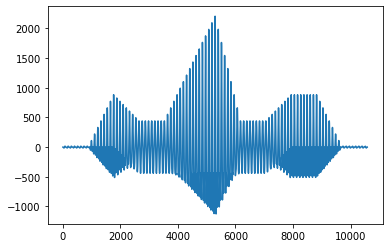

1764.0


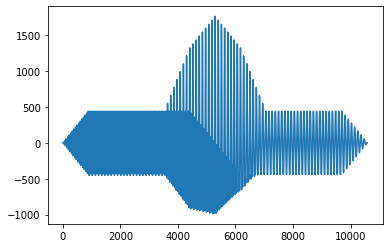

1323.0000000000005


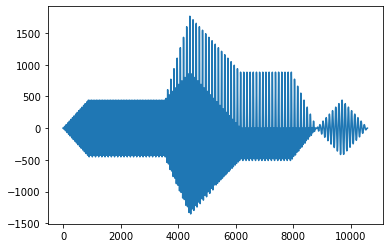

In [ ]:
bits = np.array([1,0,0,1,1,0])

tx = fsk(bitseq = bits, spb = samps, f_0 = f0, f_1 = f1, F = fs)
setup_plot("Modulated Signal")
plt.plot(tx, 'c')
plt.show()

rtt = np.correlate(tx, tx, mode ="full")
print(rtt[samps*bits.shape[0]-1])
plt.plot(rtt)
plt.show()


"""plt.plot(tx**2, 'g')
plt.show()
max = np.sum(tx**2)
print(max)"""

#1-bit difference
bits1 = np.array([1,0,0,0,1,0]) 
rx = fsk(bitseq = bits1, spb = samps, f_0 = f0, f_1 = f1, F = fs)

rtr = np.correlate(tx, rx, mode ="full")
print(rtr[samps*bits.shape[0]-1])
plt.plot(rtr)
plt.show()


#2-bit difference
bits1 = np.array([0,0,0,1,1,1]) 
rx = fsk(bitseq = bits1, spb = samps, f_0 = f0, f_1 = f1, F = fs)

rtr = np.correlate(tx, rx, mode ="full")
print(rtr[samps*bits.shape[0]-1])
plt.plot(rtr)
plt.show()


#3-bit difference
bits1 = np.array([0,1,0,1,1,1]) 
rx = fsk(bitseq = bits1, spb = samps, f_0 = f0, f_1 = f1, F = fs)

rtr = np.correlate(tx, rx, mode ="full")
print(rtr[samps*bits.shape[0]-1])
plt.plot(rtr)
plt.show()

#Alternating 1/0 Pattern

**Lengths**
*   12-bit


**Outputs**:
1.   Binary autocorrelation
2.   Binary XNOR logic autocorrelation
3.   FSK modulated signal autocorrelation
4.   Chirped FSK modulated signal autocorrelation

***12-bit Alternating***

12


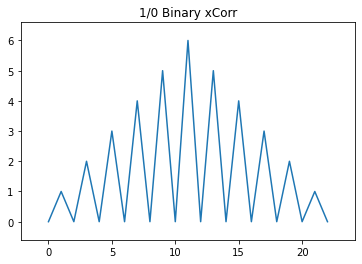

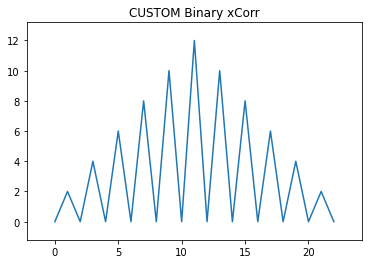

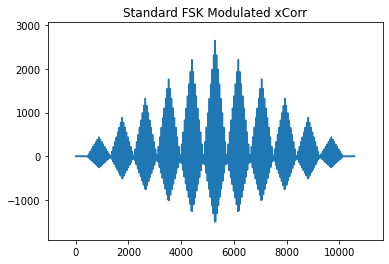

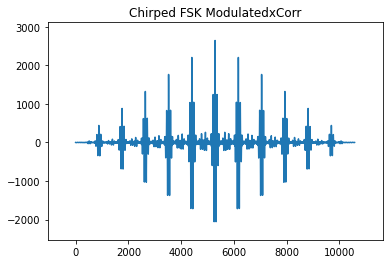

In [ ]:
Alternating10 = np.array([1,0,1,0,1,0,1,0,1,0,1,0])
show_corr_outs(Alternating10, f0, f1, fs, samps, dsamp, delta_f)

#BARKER CODES

**Lengths**
*   11-bit
*   13-bit


**Outputs**:
1.   Autocorrelation for mark = 1 and space = -1
2.   Binary autocorrelation
3.   Binary XNOR logic autocorrelation
4.   FSK modulated signal autocorrelation
5.   Chirped FSK modulated signal autocorrelation









***11-bit Barker***

11


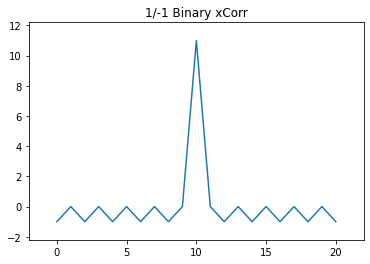

11


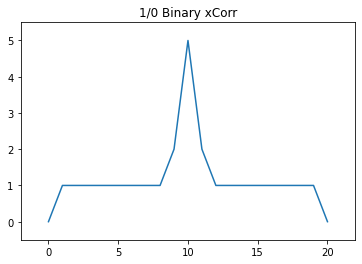

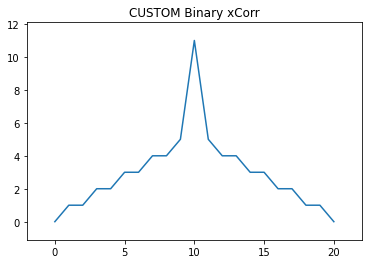

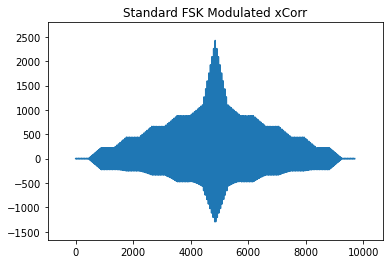

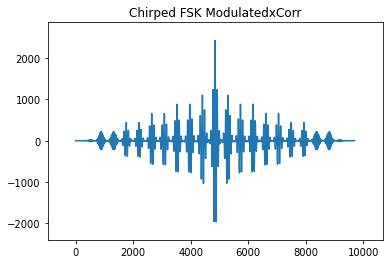

In [ ]:
org_Barker11 = np.array([1,1,1,-1,-1,-1,1,-1,-1,1,-1])
print(org_Barker11.shape[0])
rbb = np.correlate(org_Barker11, org_Barker11, mode = "full")
setup_plot("1/-1 Binary xCorr")
plt.plot(rbb)
plt.show()


Barker11 = np.array([1,1,1,0,0,0,1,0,0,1,0])
show_corr_outs(Barker11, f0, f1, fs, samps, dsamp, delta_f)

***13-bit Barker***

13


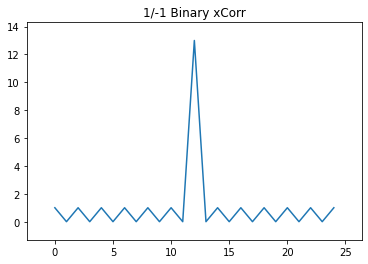

13


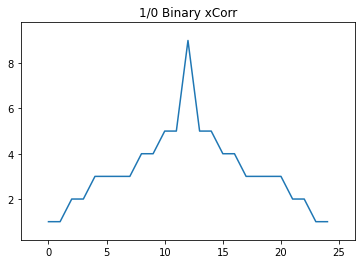

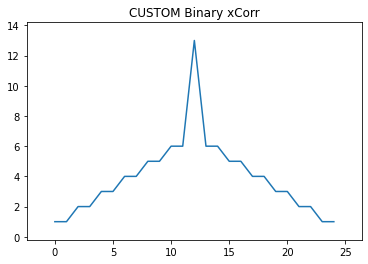

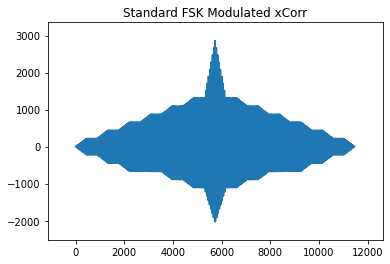

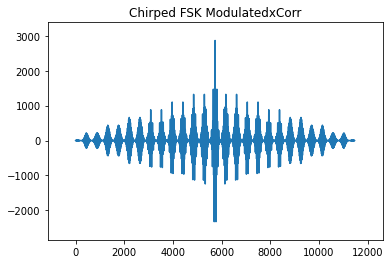

In [ ]:
org_Barker13 = np.array([1,1,1,1,1,-1,-1,1,1,-1,1,-1,1])
print(org_Barker13.shape[0])
rbb = np.correlate(org_Barker13, org_Barker13, mode = "full")
setup_plot("1/-1 Binary xCorr")
plt.plot(rbb)
plt.show()

Barker13 = np.array([1,1,1,1,1,0,0,1,1,0,1,0,1])
show_corr_outs(Barker13, f0, f1, fs, samps, dsamp, delta_f)

#Natural Legendre

**Lengths**
* 10-bit (n=11)  
* 12-bit (n=13)

**Outputs**:
1.   Binary autocorrelation
2.   Binary XNOR logic autocorrelation
3.   FSK modulated signal autocorrelation
4.   Chirped FSK modulated signal autocorrelation


***10-bit Legendre***

10


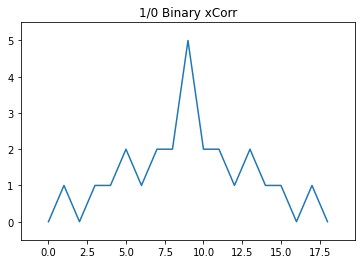

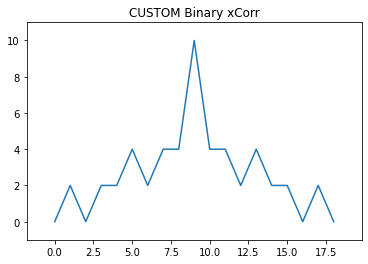

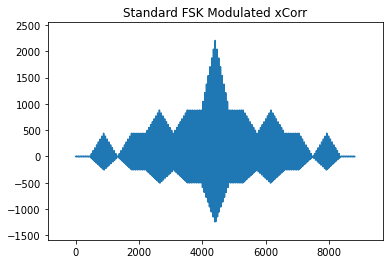

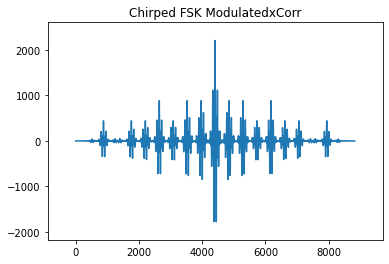

In [ ]:
"""
bit = np.array([1, -1, 1, 1, 1, -1, -1, -1, 1, -1])
print(bit.shape[0])
rbb = np.correlate(bit, bit, mode = "full")
setup_plot("1/-1 xCorr")
plt.plot(rbb)
plt.show()
"""

Legendre10 = np.array([1, 0, 1, 1, 1, 0, 0, 0, 1, 0])
show_corr_outs(Legendre10, f0, f1, fs, samps, dsamp, delta_f)

***12-bit Legendre***

12


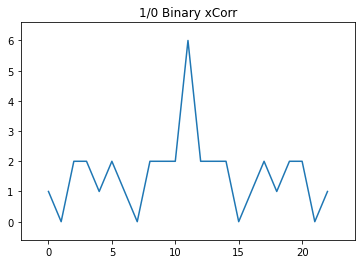

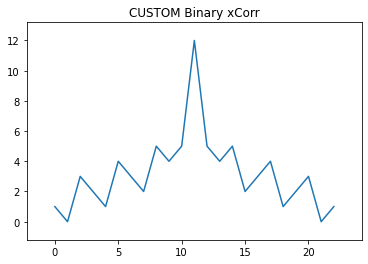

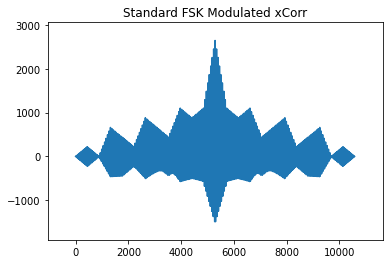

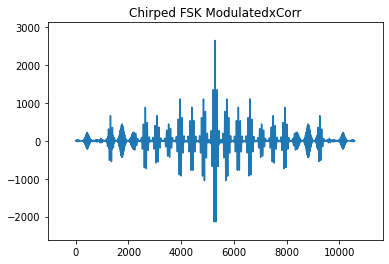

In [158]:
"""bit = np.array([1, -1, 1, 1, -1, -1, -1, -1, 1, 1, -1, 1])
print(bit.shape[0])
rbb = np.correlate(bit, bit, mode = "full")
setup_plot("1/-1 xCorr")
plt.plot(rbb)
plt.show()"""

Legendre12 = np.array([1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1])
show_corr_outs(Legendre12, f0, f1, fs, samps, dsamp, delta_f)

#WILLIARD CODES

**Lengths**
*   11-bits
*   12-bits
*   13-bits

**Outputs**:
1.   Binary autocorrelation
2.   Binary XNOR logic autocorrelation
3.   FSK modulated signal autocorrelation
4.   Chirped FSK modulated signal autocorrelation

***11-bit Williard***

11


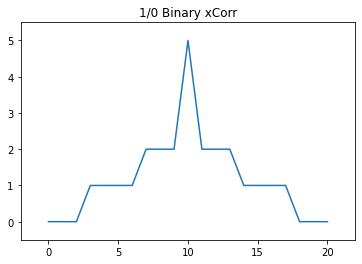

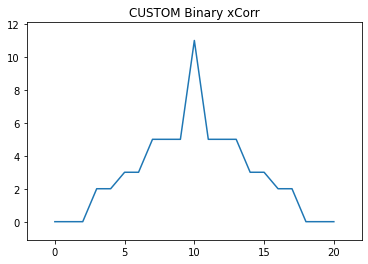

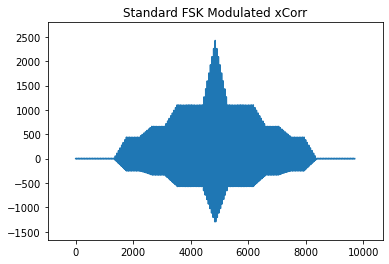

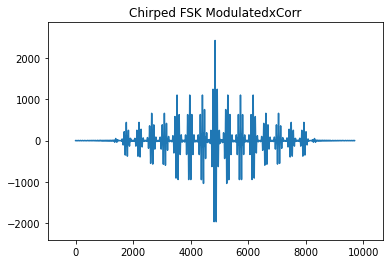

In [ ]:
"""bit = np.array([-1, -1, -1, 1, -1, -1, 1, -1, 1, 1, 1])
print(bit.shape[0])
rbb = np.correlate(bit, bit, mode = "full")
setup_plot("1/-1 xCorr")
plt.plot(rbb)
plt.show()"""

Williard11 = np.array([0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1])
show_corr_outs(Williard11, f0, f1, fs, samps, dsamp, delta_f)

***12-bit Williard***

12


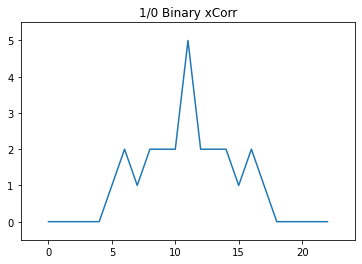

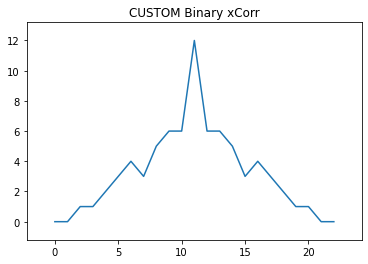

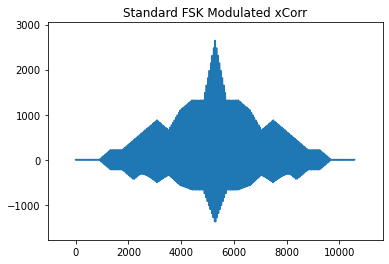

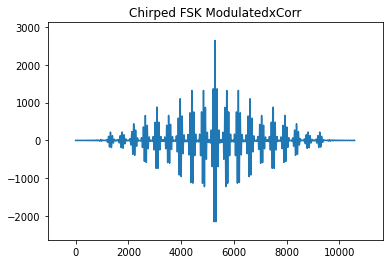

In [ ]:
"""bit = np.array([-1, -1, -1, -1, -1, 1, 1, -1, 1, -1, 1, 1])
print(bit.shape[0])
rbb = np.correlate(bit, bit, mode = "full")
setup_plot("1/-1 xCorr")
plt.plot(rbb)
plt.show()"""

Williard12 = np.array([0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1])
show_corr_outs(Williard12, f0, f1, fs, samps, dsamp, delta_f)

***13-bit Williard***

13


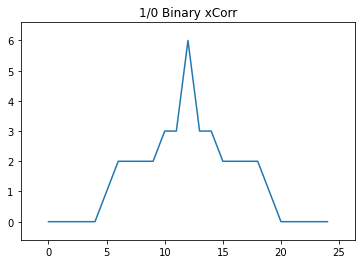

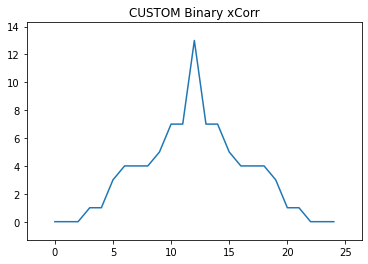

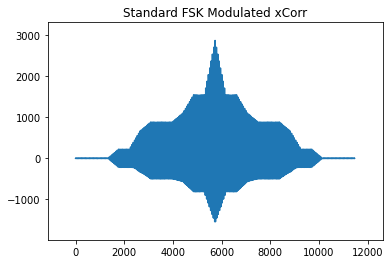

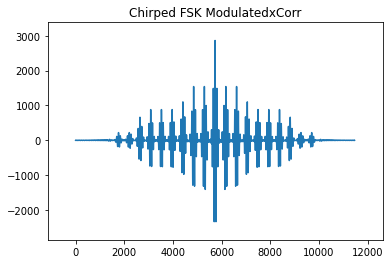

In [ ]:
"""bit = np.array([-1, -1, -1, -1, -1, 1, 1, -1, 1, -1, 1, 1, 1])
print(bit.shape[0])
rbb = np.correlate(bit, bit, mode = "full")
setup_plot("1/-1 xCorr")
plt.plot(rbb)
plt.show()"""

Williard13 = np.array([0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1])
show_corr_outs(Williard13, f0, f1, fs, samps, dsamp, delta_f)

#MAURY-STYLES CODES

**Lengths**
*   11-bits
*   12-bits
*   13-bits

**Outputs**:
1.   Binary autocorrelation
2.   Binary XNOR logic autocorrelation
3.   FSK modulated signal autocorrelation
4.   Chirped FSK modulated signal autocorrelation

***11-bit Maury-Styles***

11


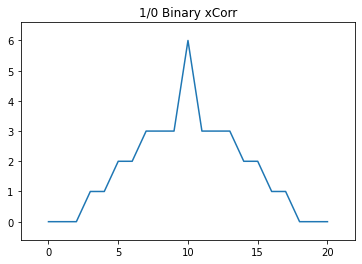

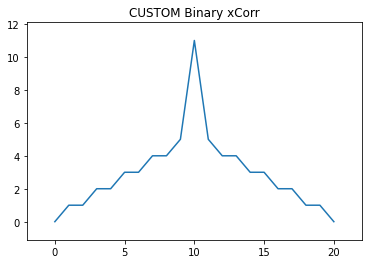

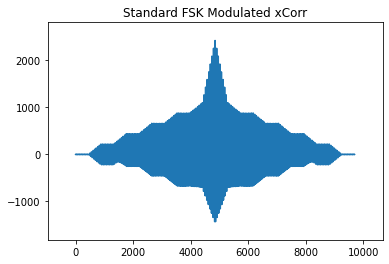

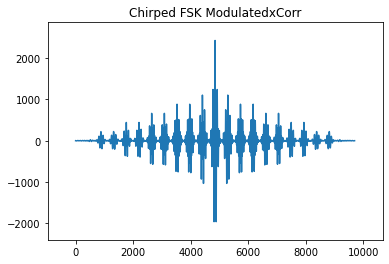

In [ ]:
"""bit = np.array([1, -1, 1, 1, -1, 1, 1, 1, -1, -1, -1])
print(bit.shape[0])
rbb = np.correlate(bit, bit, mode = "full")
setup_plot("1/-1 xCorr")
plt.plot(rbb)
plt.show()"""

MauryStyles11 = np.array([1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0])
show_corr_outs(MauryStyles11, f0, f1, fs, samps, dsamp, delta_f)

***12-bit Maury-Styles***

12


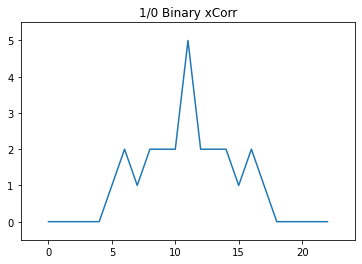

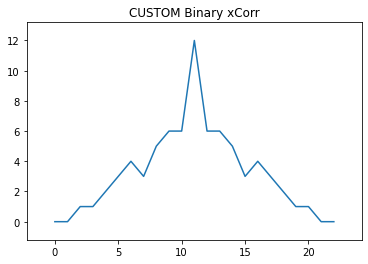

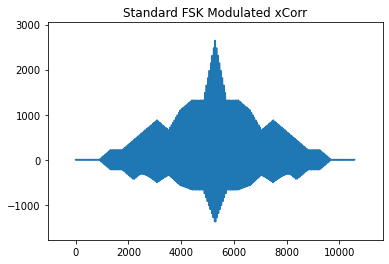

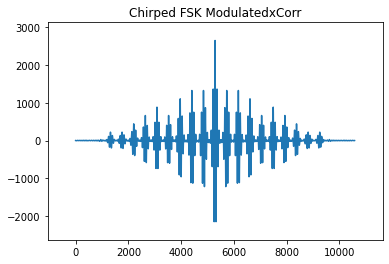

In [ ]:
"""bit = np.array([1, 1, -1, 1, -1, 1, 1, -1, -1, -1, -1, -1])
print(bit.shape[0])
rbb = np.correlate(bit, bit, mode = "full")
setup_plot("1/-1 xCorr")
plt.plot(rbb)
plt.show()"""

MauryStyles12 = np.array([1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0])
show_corr_outs(MauryStyles12, f0, f1, fs, samps, dsamp, delta_f)

***13-bit Maury-Styles***

13


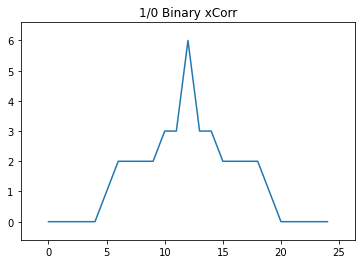

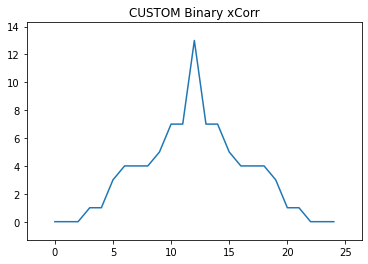

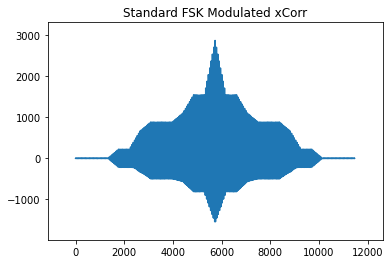

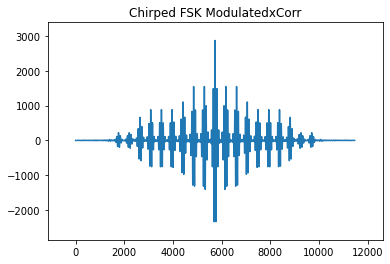

In [ ]:
"""bit = np.array([1, 1, 1, -1, 1, -1, 1, 1, -1, -1, -1, -1, -1])
print(bit.shape[0])
rbb = np.correlate(bit, bit, mode = "full")
setup_plot("1/-1 xCorr")
plt.plot(rbb)
plt.show()"""

MauryStyles13 = np.array([1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0])
show_corr_outs(MauryStyles13, f0, f1, fs, samps, dsamp, delta_f)

#Optimum 12-bit Binary Codes



1.   Initialize and define
2.   Populate matrix (integer;  peak-to-sidelobe ratio;  binary character;  XNOR correlation)
3.   Sort by siedlobe ratio (SLR)
4.   Delete entries which do not meet defined treshold SLR 
5.   Delete entries with defined no. repeated binary characters
6.   Remove entries within defined Hamming distance



In [146]:
BITS = 12
MAX = 2**BITS
vals = np.array(range(0, MAX))
print(vals)

[   0    1    2 ... 4093 4094 4095]


In [147]:
num = 0
slr = num+1
bit_begin = slr+1
bit_end = bit_begin+BITS
rxx_begin = bit_end+1
rxx_end = rxx_begin + 2*BITS - 1  

print(num, slr, bit_begin, bit_end, rxx_begin, rxx_end)
print()

A = np.zeros( shape = (MAX, rxx_end))

A[:,num] = np.array(range(0, MAX))

A[:, bit_begin:bit_end] = vec_bin_array(arr = vals, m = BITS)

for i in vals:
  bin_seq = A[i, bit_begin:bit_end]
  bin_rxx = xnor_autocorr(bin_seq)
  A[i, rxx_begin:rxx_end] = bin_rxx

  max_lobe = bin_rxx[0]
  for k in range(1, BITS-1):
      if bin_rxx[k] > max_lobe:
        max_lobe = bin_rxx[k]

  A[i, slr] =  max_lobe/bin_rxx[BITS-1]

A = A[A[:,slr].argsort()]
print(A[:, num:slr+1])

0 1 2 14 15 38

[[3.24400000e+03 3.33333343e-01]
 [8.51000000e+02 3.33333343e-01]
 [3.17800000e+03 4.16666657e-01]
 ...
 [2.04700000e+03 8.33333313e-01]
 [0.00000000e+00 9.16666687e-01]
 [4.09500000e+03 9.16666687e-01]]


In [149]:
B = A

xcor_thresh = 11
dels = []

bdel = np.zeros( shape = (B.shape[0],) )

for i in range(0, B.shape[0]):
  if bdel[i] == 0:
    
    for k in range(i+1, B.shape[0]):
      if bdel[k] == 0:
        bitseq1 = B[i, bit_begin:bit_end]
        bitseq2 = B[k, bit_begin:bit_end]
        rik = xnor_xcorr(bitseq1, bitseq2)
        rik_max = np.max(rik)
        if ( rik_max >= xcor_thresh):
          bdel[k] = 1
          dels.append(k)

A_xcor11= np.delete(B, obj = np.array(dels), axis = 0)
print(A_xcor11.shape[0])

print(A_xcor11[:, bit_begin:bit_end])

754
[[1. 1. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 1. 1.]
 [1. 1. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [1. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 1. 1. 1.]]


In [150]:
B = A_xcor11

xcor_thresh = 9
dels = []

bdel = np.zeros( shape = (B.shape[0],) )

for i in range(0, B.shape[0]):
  if bdel[i] == 0:
    
    for k in range(i+1, B.shape[0]):
      if bdel[k] == 0:
        bitseq1 = B[i, bit_begin:bit_end]
        bitseq2 = B[k, bit_begin:bit_end]
        rik = xnor_xcorr(bitseq1, bitseq2)
        rik_max = np.max(rik)
        if ( rik_max >= xcor_thresh):
          bdel[k] = 1
          dels.append(k)

          """print("#############")

          print("Match: ", i, k)
          print("Index: " , np.where(rik == rik_max)[0] )
          print(bitseq1)
          print(bitseq2)
          print("XNOR xCorr Peak", np.max(rik))"""
          
          #plt.plot( rik )
          #plt.show()

A_xcor9 = np.delete(B, obj = np.array(dels), axis = 0)
print(A_xcor9.shape[0])

print(A_xcor9[:, bit_begin:bit_end])

23
[[1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1.]
 [0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0.]
 [0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0.]
 [1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1.]
 [0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0.]
 [1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1.]
 [0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0.]
 [1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0.]
 [1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0.]
 [0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1.]
 [0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1.]
 [1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1.]
 [1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1.]
 [1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1.]
 [0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1.]
 [1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0.]
 [1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0.]
 [0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1.]
 [1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


In [156]:
B = A_xcor9

xcor_thresh = 8
dels = []

bdel = np.zeros( shape = (B.shape[0],) )

for i in range(0, B.shape[0]):
  if bdel[i] == 0:
    bitseq1 = B[i, bit_begin:bit_end]
    
    for k in range(i+1, B.shape[0]):
        if bdel[k] == 0:
          bitseq2 = B[k, bit_begin:bit_end]
          rik = xnor_xcorr(bitseq1, bitseq2)
          rik_max = np.max(rik)
          if ( rik_max >= xcor_thresh):
            bdel[k] = 1
            dels.append(k)

A_xcor9check = np.delete(B, obj = np.array(dels), axis = 0)
print(A_xcor9check.shape[0])

print(A_xcor9check[:, bit_begin:bit_end])

3
[[1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1.]
 [0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0.]]


In [159]:
bestcodes = np.array([
 [1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0.],
 [0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1.],
 [0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0.],
 [0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0.],
 [0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0.],
 [1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1.],
 [0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0.],
 [1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1.],
 [0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0.],
 [1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0.],
 [1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0.],
 [0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1.],
 [0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1.],
 [1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1.],
 [1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1.],
 [1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1.],
 [0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.],
 [1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0.],
 [1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0.],
 [1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0.],
 [0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1.],
 [1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1.],
 [1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]
 ])

print(A_xcor9[:, bit_begin:bit_end] - bestcodes)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


3244.0
[1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0.]


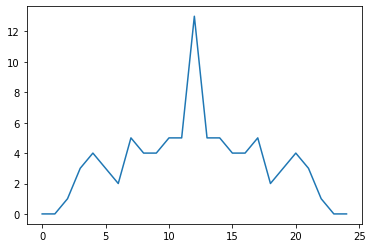

851.0
[0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0.]


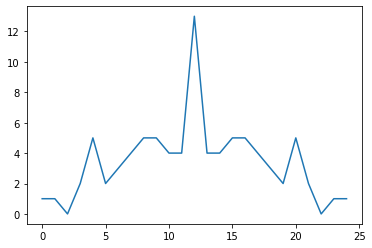

788.0
[0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0.]


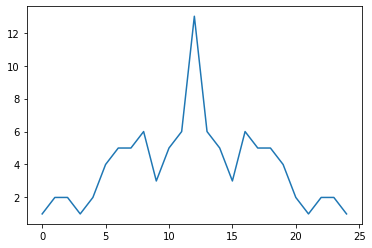

1850.0
[0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0.]


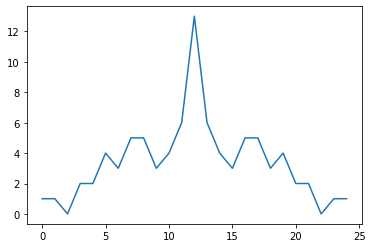

1864.0
[0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0.]


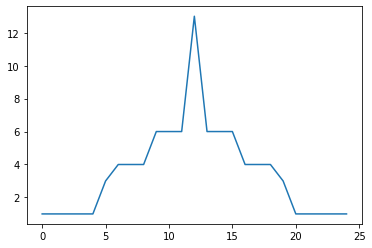

3431.0
[1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0.]


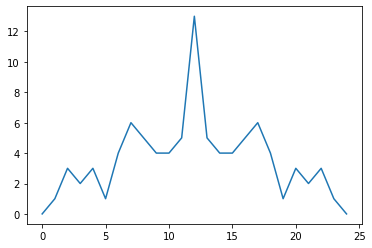

738.0
[0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0.]


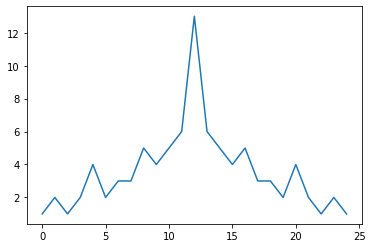

3389.0
[1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0.]


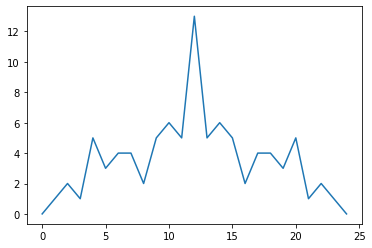

732.0
[0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0.]


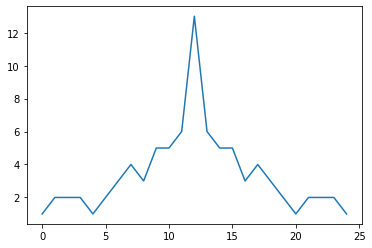

2856.0
[1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0.]


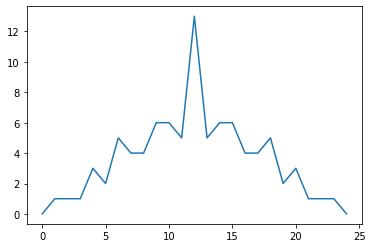

2886.0
[1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0.]


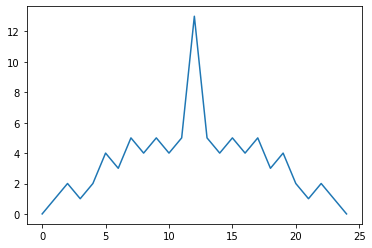

1483.0
[0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0.]


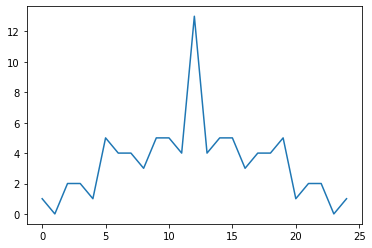

333.0
[0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0.]


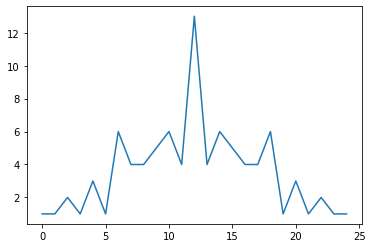

2225.0
[1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0.]


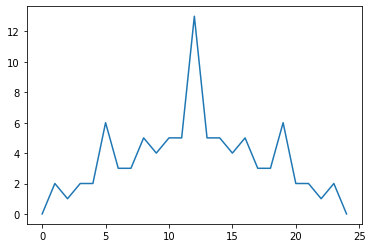

2249.0
[1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0.]


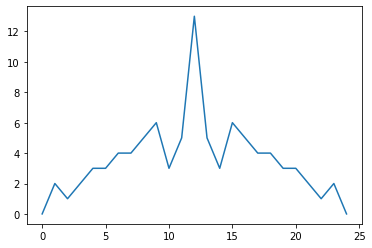

3115.0
[1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0.]


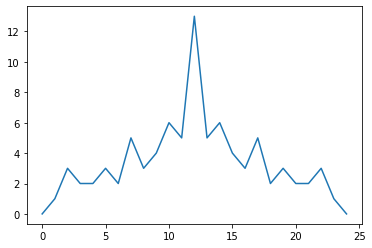

1647.0
[0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0.]


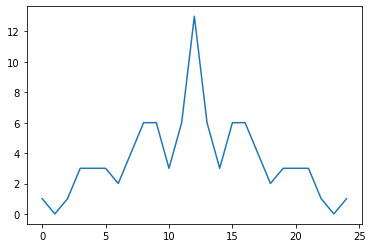

3126.0
[1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0.]


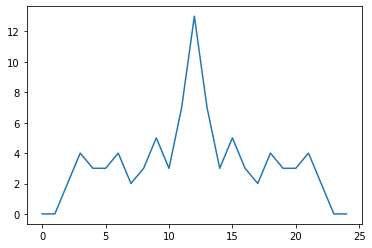

2550.0
[1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0.]


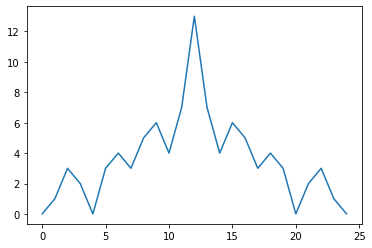

2074.0
[1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0.]


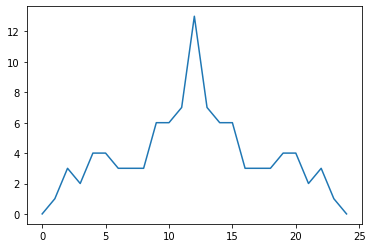

1249.0
[0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0.]


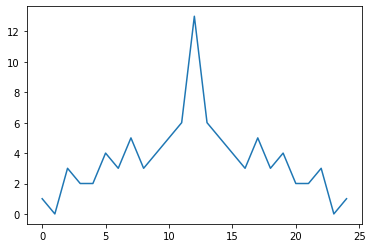

3065.0
[1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0.]


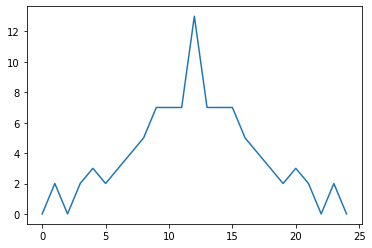

2052.0
[1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


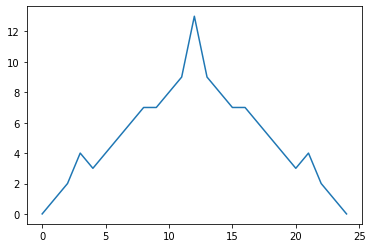

In [187]:
for i in range (0, A_xcor9.shape[0]):
  rii = xnor_xcorr(A_xcor9[ i, bit_begin : bit_end ], A_xcor9[ i, bit_begin : bit_end ])

  print( A_xcor9[ i, num ] )
  print( A_xcor9[ i, bit_begin : bit_end ] )

  plt.plot( rii )
  plt.show()

#Optimum 13-bit Binary Codes



1.   Initialize and define
2.   Populate matrix (integer;  peak-to-sidelobe ratio;  binary character;  XNOR correlation)
3.   Sort by siedlobe ratio (SLR)
4.   Delete entries which do not meet defined treshold SLR 
5.   Delete entries with defined no. repeated binary characters
6.   Remove entries within defined Hamming distance

In [175]:
BITS = 13
MAX = 2**BITS
vals = np.array(range(0, MAX))
print(vals)

num = 0
slr = num+1
bit_begin = slr+1
bit_end = bit_begin+BITS
rxx_begin = bit_end+1
rxx_end = rxx_begin + 2*BITS - 1  

print(num, slr, bit_begin, bit_end, rxx_begin, rxx_end)
print()

[   0    1    2 ... 8189 8190 8191]
0 1 2 15 16 41



In [176]:
E = np.zeros( shape = (MAX, rxx_end))

E[:,num] = np.array(range(0, MAX))

E[:, bit_begin:bit_end] = vec_bin_array(arr = vals, m = BITS)

for i in vals:
  bin_seq = E[i, bit_begin:bit_end]
  bin_rxx = xnor_autocorr(bin_seq)
  E[i, rxx_begin:rxx_end] = bin_rxx

  max_lobe = bin_rxx[0]
  for k in range(1, BITS-1):
      if bin_rxx[k] > max_lobe:
        max_lobe = bin_rxx[k]

  E[i, slr] =  max_lobe/bin_rxx[BITS-1]

E = E[E[:,slr].argsort()]
print(E[:, num:slr+1])

[[5.35600000e+03 3.84615391e-01]
 [5.22500000e+03 3.84615391e-01]
 [5.22800000e+03 3.84615391e-01]
 ...
 [4.09500000e+03 8.46153855e-01]
 [0.00000000e+00 9.23076928e-01]
 [8.19100000e+03 9.23076928e-01]]


In [139]:
B = E

xcor_thresh = BITS-1
dels = []

bdel = np.zeros( shape = (B.shape[0],) )

for i in range(0, B.shape[0]):
  if bdel[i] == 0:
    #print(i)
    for k in range(i+1, B.shape[0]): 
        if bdel[k] == 0:
          bitseq1 = B[i, bit_begin:bit_end]
          bitseq2 = B[k, bit_begin:bit_end]
          rik = xnor_xcorr(bitseq1, bitseq2)
          rik_max = np.max(rik)
          if ( rik_max >= xcor_thresh):
            bdel[k] = 1
            dels.append(k)

E_xcor11= np.delete(B, obj = np.array(dels), axis = 0)
print(E_xcor11.shape[0])

print(E_xcor11[:, bit_begin:bit_end])

0
1
3
4
5
6
7
10
12
13
16
17
18
19
20
22
23
24
25
27
29
32
38
39
41
44
45
47
49
50
51
52
56
57
59
60
61
62
63
64
66
68
72
77
79
80
81
82
85
87
88
93
94
95
96
97
101
103
105
107
108
109
112
114
117
118
119
123
126
128
129
131
134
136
139
141
144
148
149
154
155
156
158
159
162
163
164
166
177
178
181
185
189
190
191
195
196
197
199
200
204
206
207
208
210
215
218
221
223
225
235
237
238
239
240
241
243
247
251
254
260
261
262
267
270
271
272
277
278
282
283
284
288
293
302
303
309
310
311
316
320
326
329
334
338
340
342
344
345
351
352
353
355
358
361
370
373
374
381
385
386
388
389
391
393
396
401
406
411
415
417
421
425
434
437
438
447
452
463
464
469
473
477
480
483
487
489
490
494
497
498
503
504
505
508
510
514
515
517
519
520
522
523
530
532
542
544
549
554
556
557
559
560
563
568
569
575
581
583
584
585
586
588
589
592
597
600
604
611
616
617
619
620
627
633
641
643
650
655
657
663
666
668
671
672
674
675
677
678
681
682
684
685
687
691
696
698
703
707
713
716
718
722
724
730
735

In [140]:
B = E_xcor11

xcor_thresh = 9
dels = []

bdel = np.zeros( shape = (B.shape[0],) )

for i in range(0, B.shape[0]):
  if bdel[i] == 0:
    bitseq1 = B[i, bit_begin:bit_end]
    
    for k in range(i+1, B.shape[0]):
        if bdel[k] == 0:
          bitseq2 = B[k, bit_begin:bit_end]
          rik = xnor_xcorr(bitseq1, bitseq2)
          rik_max = np.max(rik)
          if ( rik_max >= xcor_thresh):
            bdel[k] = 1
            dels.append(k)

            """print("#############")

            print("Match: ", i, k)
            print("Index: " , np.where(rik == rik_max)[0] )
            print(bitseq1)
            print(bitseq2)
            print("XNOR xCorr Peak", np.max(rik))"""
            
            #plt.plot( rik )
            #plt.show()

E_xcor9 = np.delete(B, obj = np.array(dels), axis = 0)
print(E_xcor9.shape[0])

print(E_xcor9[:, bit_begin:bit_end])

12
[[1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0.]
 [1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0.]
 [0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1.]
 [0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0.]
 [0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1.]
 [1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0.]
 [0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1.]
 [0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0.]
 [1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1.]]


3244.0
[1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0.]


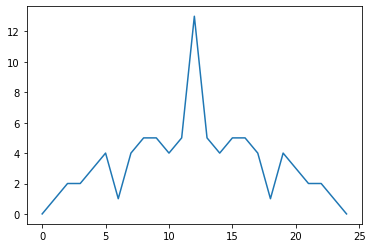

851.0
[0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0.]


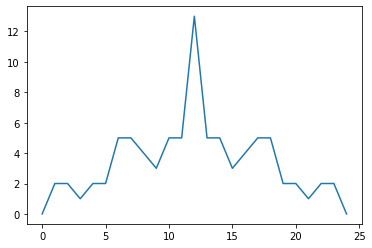

788.0
[0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0.]


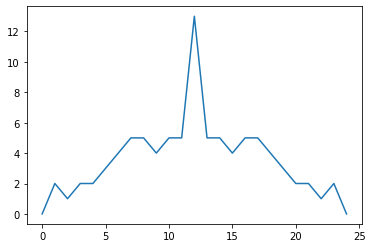

1850.0
[0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0.]


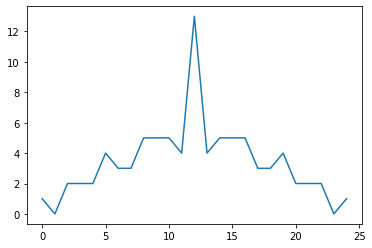

1864.0
[0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0.]


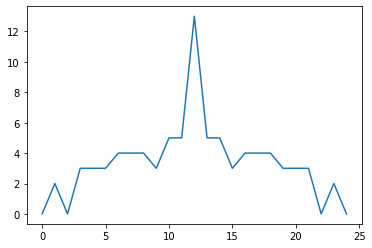

3431.0
[1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0.]


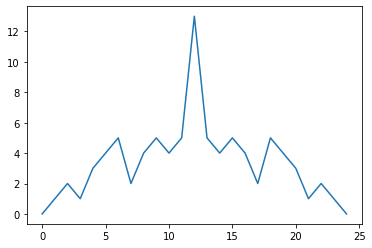

738.0
[0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0.]


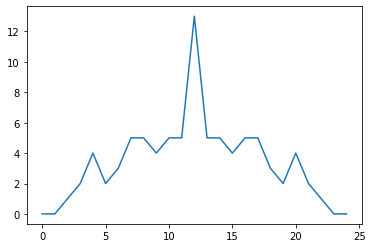

3389.0
[1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0.]


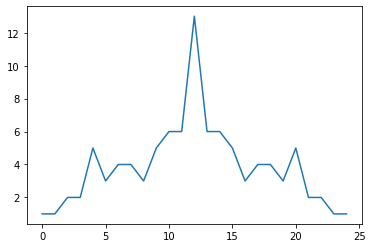

732.0
[0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0.]


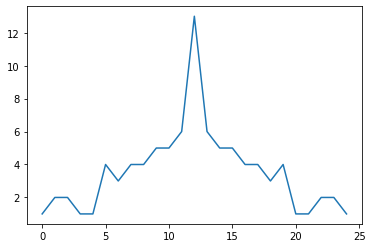

2856.0
[1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0.]


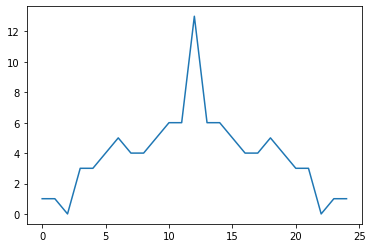

2886.0
[1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0.]


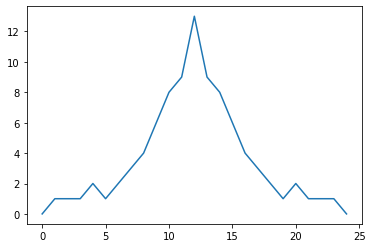

1483.0
[0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0.]


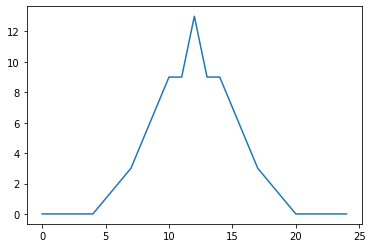

In [186]:
for i in range (0, E_xcor9.shape[0]):
  rii = xnor_xcorr(E_xcor9[ i, bit_begin : bit_end ], E_xcor9[ i, bit_begin : bit_end ])
  
  print( A_xcor9[ i, num ] )
  print( A_xcor9[ i, bit_begin : bit_end ] )
  
  plt.plot(rii)
  plt.show()

In [172]:
B = E_xcor9

xcor_thresh = 8
dels = []

bdel = np.zeros( shape = (B.shape[0],) )

for i in range(0, B.shape[0]):
  if bdel[i] == 0:
    bitseq1 = B[i, bit_begin:bit_end]
    
    for k in range(0, B.shape[0]):
      if not (i == k):
        if bdel[k] == 0:
          bitseq2 = B[k, bit_begin:bit_end]
          rik = xnor_xcorr(bitseq1, bitseq2)
          rik_max = np.max(rik)
          if ( rik_max >= xcor_thresh):
            bdel[k] = 1
            dels.append(k)

            """print("#############")

            print("Match: ", i, k)
            print("Index: " , np.where(rik == rik_max)[0] )
            print(bitseq1)
            print(bitseq2)
            print("XNOR xCorr Peak", np.max(rik))"""
            
            #plt.plot( rik )
            #plt.show()

E_xcor8 = np.delete(B, obj = np.array(dels), axis = 0)
print(E_xcor8.shape[0])

print(E_xcor8[:, bit_begin:bit_end])

5
[[1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0.]
 [1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1.]
 [0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1.]]


#TOGETHER

In [188]:
bit_codes12 = np.array([3244, 851,788,1850,1864,3431,738,3389,732,2856,2886,1483,333,2225,2249,3115,1647,3126,2550,
                        2074,1249,3065,2052])

bit_codes13 = np.array([3244,851,788,1850,1864,3431,738,3389,732,2856,2886,1483])

#EXCESS CODE

In [ ]:
threshold = 0.6 + 0.001
dels = []

for i in range(0, MAX):
  if (E[i, slr] > threshold):
    dels.append(i)

E_minthresh = np.delete(E, obj = np.array(dels), axis = 0)
print(E_minthresh.shape[0])

5504


5336
[[0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0.]
 [1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0.]
 [0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0.]
 [1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1.]
 [1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1.]
 [1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0.]
 [0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1.]
 [1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0.]]


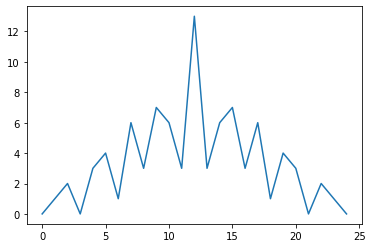

In [ ]:
rpt_thresh = int(BITS/2)
dels = []

for i in range(0, E_minthresh.shape[0]):
  rpt = 1
  bfound = 0
  for k in range(bit_begin+1, bit_end):
    if ( int(E_minthresh[i, k]) == int(E_minthresh[i, k-1]) ) and ( bfound == 0 ):
      rpt = rpt +1
    else:
      rpt = 1
    if (rpt >= rpt_thresh):
      bfound = 1
      dels.append(i)

E_rptthresh = np.delete(E_minthresh, obj = np.array(dels), axis = 0)
print(E_rptthresh.shape[0])

print( E_rptthresh[ E_rptthresh.shape[0]-10 : E_rptthresh.shape[0], bit_begin : bit_end] )
plt.plot( E_rptthresh[ E_rptthresh.shape[0]-1 , rxx_begin : rxx_end ] )

In [ ]:
"""
E_rptthresh = [[0,0,0,1,1,1,0,0,0,1,1,1,0],
               [0,0,0,1,1,1,0,0,0,1,1,1,0],
               [0,0,0,0,1,1,0,0,0,1,1,1,0],
               [0,0,0,1,1,1,1,0,0,1,1,0,0],
               [0,1,1,1,0,1,0,0,0,1,1,1,0],
               [0,0,0,1,1,1,0,0,0,1,1,1,0]]

E_rptthresh = np.array(E_rptthresh)
bit_begin = 0
bit_end = 13
"""

hamm_thresh = BITS - 2
dels = []

bdel = np.zeros( shape = (E_rptthresh.shape[0],) )

for i in range(0, E_rptthresh.shape[0]):
  if bdel[i] == 0 : 
    hamm = np.zeros( shape = (E_rptthresh.shape[0],) )

    for k in range(0, E_rptthresh.shape[0]):
      if bdel[k] == 0 :

        for j in range(bit_begin+1, bit_end):      
          if (not (i == k)) and ( int(E_rptthresh[i, j]) == int(E_rptthresh[k, j]) ) :
            hamm[k] = hamm[k] + 1

          if (hamm[k] >= hamm_thresh):
            bdel[k] = 1
            dels.append(k)

E_hammthresh = np.delete(E_rptthresh, obj = np.array(dels), axis = 0)
print(E_hammthresh.shape[0])

print(E_hammthresh[:, bit_begin:bit_end])

793
[[1. 0. 1. ... 1. 0. 0.]
 [1. 0. 1. ... 0. 0. 1.]
 [1. 0. 0. ... 1. 0. 1.]
 ...
 [0. 1. 0. ... 1. 0. 1.]
 [0. 1. 0. ... 0. 1. 1.]
 [1. 1. 0. ... 1. 1. 1.]]
